In [1]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [4] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

For the homogeneous solution, we have $u'' + u = 0$, which gives $r^2 + 1 = 0$. This implies $r = \pm i$. Thus, 
\begin{align*}
    u_h(x) = C_1 \cos(x) + C_2 \sin(x). 
\end{align*}
For particular solution, we have 
\begin{align*}
    u_p(x) = A \cos(3x) + B \sin(3x). 
\end{align*}
Substituting into equation gives 
\begin{align*}
    {u_p}'' + u_p &= -9 A \cos(3x) - 9 B \sin(3x) + A \cos(3x) + B \sin(3x) \\ 
    &= -8 A \cos(3x) - 8 B \sin(3x) \\ 
    &= \sin(3x). 
\end{align*}
This means $A = 0$, $B = -\frac{1}{8}$. We get $u_p(x) = -\frac{1}{8} \sin(3x)$. 

The solution 
\begin{align*}
    u(x) = u_h(x) + u_p(x) = C_1 \cos(x) + C_2 \sin(x) -\frac{1}{8} \sin(3x). 
\end{align*}
Using boundary condition at $0$, 
\begin{align*}
    u(0) = C_1 \times 1 + 0 - 0 = 0, 
\end{align*}
which means $C_1 = 0$. 
When at $L$, 
\begin{align*}
    u(L) = C_2 \sin(L) -\frac{1}{8} \sin(3L) = 0. 
\end{align*}

Therefore, the solution is 
\begin{align*}
    u(x) = C_2 \sin(x) -\frac{1}{8} \sin(3x), 
\end{align*}
where $C_2 \sin(L) = \frac{1}{8} \sin(3L)$. The solution is unique if $L$ is given. 

**(b)** [2]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

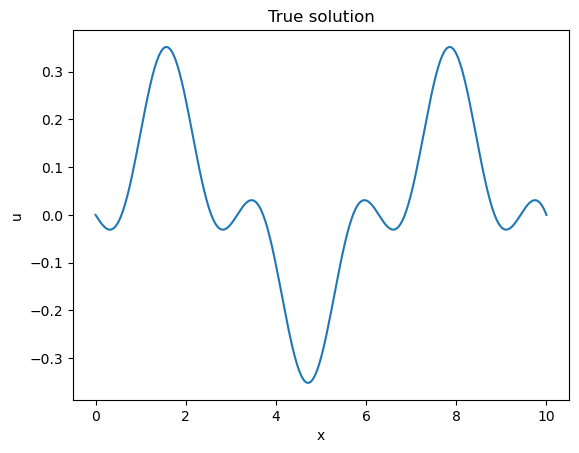

In [2]:
L = 10.
N = 200
x = numpy.linspace(0., L, N)

def u_true(x, L):
    C2 = (1/8) * numpy.sin(3.0 * L) / numpy.sin(L)
    return C2 * numpy.sin(x) - (1/8) * numpy.sin(3.0 * x)
    
plt.plot(x, u_true(x, L))
plt.xlabel('x')
plt.ylabel('u')
plt.title('True solution')
plt.show()

**(b)** [4] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [3]:
#  write a general shooting algorithm

from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-5, atol=1.e-9):
    """
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """
    
    def shoot(s):
        # Set the initial conditions, replacing the unknown with the shooting parameter s
        u0 = numpy.zeros(2)
        u0[i_a] = u_a[i_a]
        u0[1 - i_a] = s
        
        # Integrate the ODE
        sol = solve_ivp(f, [x[0], x[-1]], u0, t_eval=x, rtol=rtol, atol=atol)
        
        # Extract the solution at the endpoint
        u_end = sol.y[:, -1]
        
        # Return the error in the boundary condition at x = b
        return u_end[i_b] - u_b[i_b]
    
    # u0 = root_scalar(shoot, bracket=[-10, 10]).root
    u0 = root_scalar(shoot, x0=0).root
    # print(u0)
    u_initial = numpy.zeros(2)
    u_initial[i_a] = u_a[i_a]
    u_initial[1 - i_a] = u0
    
    sol = solve_ivp(f, [x[0], x[-1]], u_initial, t_eval=x, rtol=rtol, atol=atol, dense_output=True)
    
    return sol.sol(x)

**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

We have 
\begin{gather*}
    v = \begin{bmatrix}
        u \\
        u_x
    \end{bmatrix} = \begin{bmatrix}
        v_1 \\
        v_2
    \end{bmatrix} \\ 
    \frac{d}{dx}v = f(v) = \begin{bmatrix}
        v_2 \\
        \sin(3x) - v_1
    \end{bmatrix}
\end{gather*}

C:\Users\31040\AppData\Local\Temp\ipykernel_29972\3387050555.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u0[1 - i_a] = s


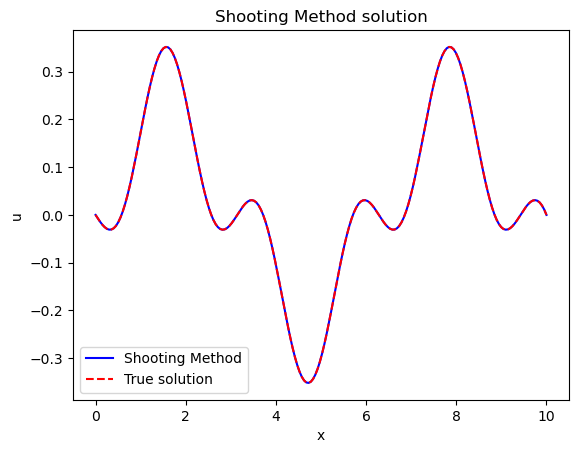

In [4]:
def f(x, u):
    return numpy.array([u[1], numpy.sin(3.*x) - u[0]])

u_0 = 0.
u_l = 0.
u_a = numpy.array([u_0, 0.])
u_b = numpy.array([u_l, 0.])
i_a = 0
i_b = 0

u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-9, atol=1.e-10)[0]

plt.plot(x, u_sol, 'b', label='Shooting Method')
plt.plot(x, u_true(x, L), 'r--', label='True solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Shooting Method solution')
plt.show()

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [5]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 4.164287900671337e-10
success


**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

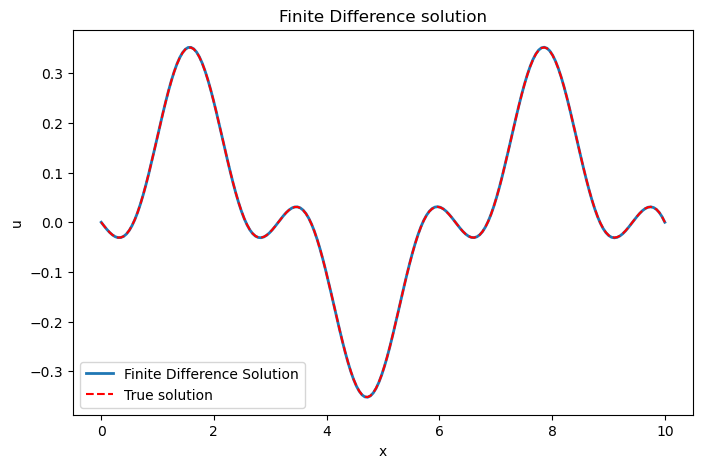

In [6]:
# routines from class  for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs

def finite_difference_bvp(a, b, n, f, boundary_conditions):
    """
    Solves the boundary value problem u'' + u = f(x) on the interval [a, b]
    using the finite difference method.
    """
    # Grid setup
    h = (b - a) / (n + 1)  # Step size
    x = numpy.linspace(a, b, n + 2)  # Include boundaries

    # System matrix
    A = numpy.zeros((n, n))
    for i in range(n):
        A[i, i] = -2 / h**2 + 1  # Central diagonal
        if i > 0:
            A[i, i - 1] = 1 / h**2  # Lower diagonal
        if i < n - 1:
            A[i, i + 1] = 1 / h**2  # Upper diagonal
    # print(A)

    # Right-hand side vector
    rhs = numpy.array([f(xi) for xi in x[1:-1]])
    rhs[0] -= boundary_conditions[0] / h**2
    rhs[-1] -= boundary_conditions[1] / h**2
    # print(rhs)

    # Solve the linear system
    u_inner = numpy.linalg.solve(A, rhs)

    # Append boundary conditions
    u = numpy.zeros(n + 2)
    u[0] = boundary_conditions[0]
    u[-1] = boundary_conditions[1]
    u[1:-1] = u_inner

    return x, u

# Parameters
a, b = 0, 10  # Domain [a, b]
n = 200  # Number of internal grid points
f = lambda x: numpy.sin(3 * x)  # Forcing function
boundary_conditions = (0, 0)  # Dirichlet conditions u(0) = 0, u(10) = 0

# Solve the problem
x, u = finite_difference_bvp(a, b, n, f, boundary_conditions)

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(x, u, label="Finite Difference Solution", linewidth=2)
plt.plot(x, u_true(x, L), 'r--', label='True solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.title('Finite Difference solution')
plt.show()

In [7]:
# x = numpy.linspace(0., L, 200)
# A = D2(x, ['dirichlet', 'dirichlet'])
# print(A.todense())
# f = RHS(x, lambda x: numpy.sin(3.*x), (0., 0.))
# # print(f)

# u = spsolve(A, f)
# plt.plot(x, u, 'b', label='Finite Difference')
# plt.plot(x, u_true(x, L), 'r', label='True solution')
# plt.xlabel('x')
# plt.ylabel('u')
# plt.legend()
# plt.title('Finite Difference solution')
# plt.show()

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

Estimated convergence rate: 2.03
N needed for relative error < 1e-6: 8945
The actual relative error using the 8945 points: 6.314278811603656e-07


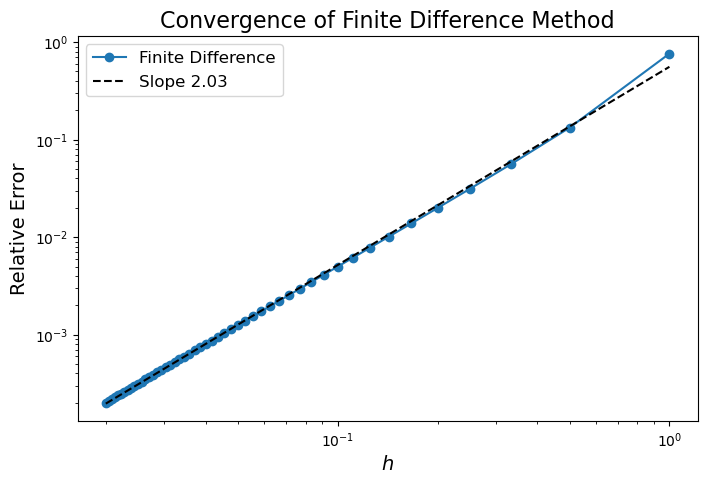

In [8]:
# Make a well labeled convergence plot that shows convergence rate of relative error vs grid spacing
n_list = numpy.linspace(10, 500, dtype=int)
rel_err_list = []
for n in n_list:
    x, u = finite_difference_bvp(a, b, n, f, boundary_conditions)
    rel_err = numpy.linalg.norm(u - u_true(x, b))/numpy.linalg.norm(u_true(x, b))
    rel_err_list.append(rel_err)
    
# Perform linear regression to estimate the convergence rate
coeffs = numpy.polyfit(numpy.log(10. / n_list), numpy.log(rel_err_list), 1)
print("Estimated convergence rate: {:.2f}".format(coeffs[0]))

# Estimate N needed for relative error < 1e-6
N_needed = 10. / numpy.exp(numpy.log(1e-6) / coeffs[0])
print("N needed for relative error < 1e-6: {:.0f}".format(N_needed))

x, u = finite_difference_bvp(a, b, int(N_needed), f, boundary_conditions)
rel_err = numpy.linalg.norm(u - u_true(x, b))/numpy.linalg.norm(u_true(x, b))
print(r'The actual relative error using the {} points: {}'.format(int(N_needed), rel_err))

# Create a log-log plot
plt.figure(figsize=(8, 5))
plt.loglog(10. / n_list, rel_err_list, 'o-', label="Finite Difference")

# Plot regression line
x_fit = numpy.linspace(0.02, 1, 100)
plt.loglog(x_fit, numpy.exp(coeffs[1]) * x_fit**coeffs[0], 'k--', label="Slope {:.2f}".format(coeffs[0]))

plt.xlabel(r"$h$", fontsize=14)
plt.ylabel("Relative Error", fontsize=14)
plt.title("Convergence of Finite Difference Method", fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [9]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = [ x0 ]
    res_list = []
    for k in range(MAX_ITS+1):
        xk = x[k]
        res = numpy.linalg.norm(F(xk))
        res_list.append(res)
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return numpy.array(x), k, res_list
        delta = spsolve(J(xk),-F(xk))
        x.append( xk + delta)
        
        
                
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

In [10]:
N = 300
L = 10
x = numpy.linspace(0., L, N)
A = D2(x)
def F(u):
    f = A.dot(u) + numpy.sin(u) - numpy.sin(3.*x)
    f[[0, -1]] = 0
    return f

def J(u):
    n = len(u)
    return A + spdiags(numpy.cos(u), 0, n, n)

u0 = numpy.linspace(0., 0., N)
sol, its, res_list = newton(F, J, u0)

k = 0, ||F|| = 12.238007718712746
k = 1, ||F|| = 0.04902986687134196
k = 2, ||F|| = 0.0013936709788684015
k = 3, ||F|| = 1.8881243570763462e-06
k = 4, ||F|| = 3.682757724046431e-12


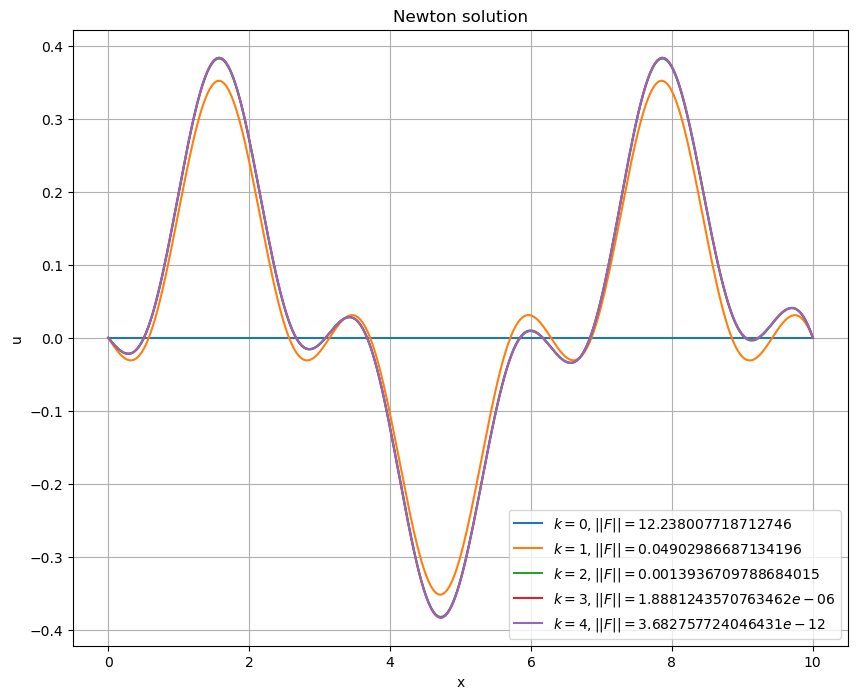

In [11]:
plt.figure(figsize=(10,8))
for k in range(its+1):
    plt.plot(x,sol[k],label='$k={}, ||F||={}$'.format(k, res_list[k]))
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.title('Newton solution')
plt.show()

**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

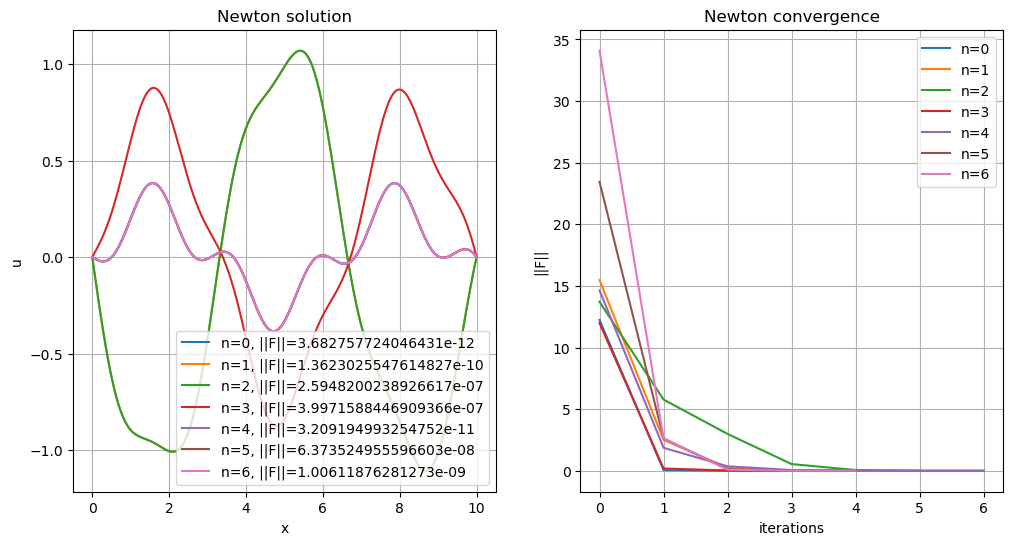

In [12]:
N = 300
x = numpy.linspace(0., L, N)
A = D2(x)
def F(u):
    f = A.dot(u) + numpy.sin(u) - numpy.sin(3.*x)
    f[[0, -1]] = 0
    return f

def J(u):
    n = len(u)
    return A + spdiags(numpy.cos(u), 0, n, n)

def initial_condition(n, x, L):
    return numpy.sin(n * numpy.pi * x / L)

u0 = numpy.linspace(0., 0., N)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for n in range(7):
    u0 = initial_condition(n, x, L)
    u0[[0, -1]] = 0
    sol, its, res_list = newton(F, J, u0, verbose=False)
    ax1.plot(x,sol[-1],label='n={}, ||F||={}'.format(n, res_list[-1]))
    ax2.plot(res_list, label='n={}'.format(n))
ax1.grid()
ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Newton solution')

ax2.grid()
ax2.legend()
ax2.set_xlabel('iterations')
ax2.set_ylabel('||F||')
ax2.set_title('Newton convergence')
plt.show()

There are other solutions. 

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?